In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Set-up Starting Guesses

In [3]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
# make some elements zero
R[0,2] = 0
R[1,2] = 0
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.41556993, 0.58443007, 0.        ],
        [0.62952342, 0.37047658, 0.        ],
        [0.2629527 , 0.44487695, 0.29217036]]),
 array([1., 1., 1.]))

In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
np.sum(T, axis=1)
T

array([[0.86130455, 0.13869545, 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.        , 0.89305456, 0.10694544],
       [0.        , 0.        , 0.        , 1.        ]])

In [5]:
start = np.zeros((M, C))
start[0, 1] = 0.1

## Set-up unbiased Joint

In [6]:
unbiased_model = maxentep.parameter_joint(start, R, T, 0.2, name='unbiased')
unbiased_joint = unbiased_model(tf.constant([1.]))

## Create Trainable Joint

In [7]:
model = maxentep.parameter_joint(start, R, T, 0.2, name='param-model')

## Set-up loglikelihood

In [8]:
model.compile(tf.optimizers.Adam(1e-3), loss=len(unbiased_joint) * [maxentep.negloglik])
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (1, 2, 3, 3)         18          input_2[0][0]                    
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (1, 4, 4)            16          input_2[0][0]                    
__________________________________________________________________________________________________
rho-dist-hypers (TrainableInput (1, 2, 3, 4)         24          input_2[0][0]                    
__________________________________________________________________________________

## Make some restraints

In [9]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [10]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [11]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

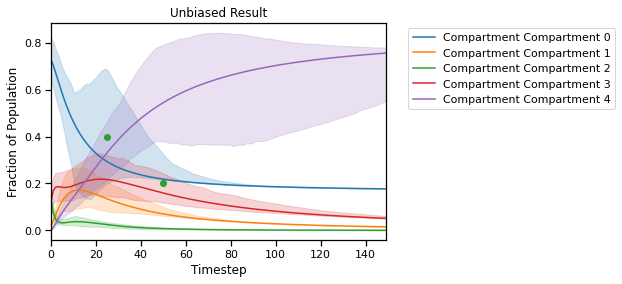

In [12]:
psample = [j.sample(param_batch_size) for j in unbiased_joint]
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [13]:
me_loss = []
# sample and get batch
joint = model(tf.constant([0.]))
psample = [j.sample(param_batch_size) for j in joint]    
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

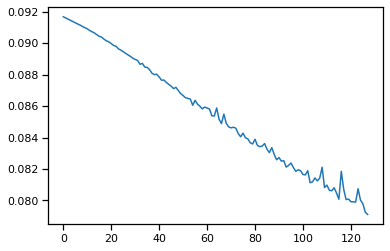

In [14]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

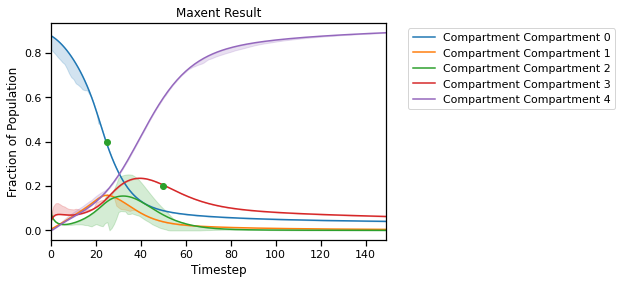

In [15]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [21]:
maxent_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
maxent_model.fit(param_batch_size, 16, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 719us/step - loss: 0.0669
Epoch 2/8
32/32 [==============================] - 0s 687us/step - loss: 0.0651
Epoch 3/8
32/32 [==============================] - 0s 719us/step - loss: 0.0633
Epoch 4/8
32/32 [==============================] - 0s 750us/step - loss: 0.0615
Epoch 5/8
32/32 [==============================] - 0s 875us/step - loss: 0.0598
Epoch 6/8
32/32 [==============================] - 0s 767us/step - loss: 0.0571
Epoch 7/8
32/32 [==============================] - 0s 844us/step - loss: 0.0557
Epoch 8/8
32/32 [==============================] - 0s 844us/step - loss: 0.0541
Epoch 1/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9321 - R-dist-dist_loss: -0.0394 - T-dist-dist_loss: -0.5760 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0289
Epoch 2/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9321 - R-dist-dist_loss: -0.0394 - T-dist-dist_loss: -0.5760 - rho-dist-dist_loss: -0.2877 - be

Epoch 3/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9316 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5762 - rho-dist-dist_loss: -0.2878 - beta-dist_loss: -0.0281
Epoch 4/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9317 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5762 - rho-dist-dist_loss: -0.2878 - beta-dist_loss: -0.0281
Epoch 5/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9316 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5762 - rho-dist-dist_loss: -0.2878 - beta-dist_loss: -0.0281
Epoch 6/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9317 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5763 - rho-dist-dist_loss: -0.2878 - beta-dist_loss: -0.0281
Epoch 7/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9317 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5763 - rho-dist-dist_loss: -0.2878 - beta-dist_loss: -0.0281
Epoch 8/8
32/32 [============================

32/32 [==============================] - 0s 750us/step - loss: 0.0045
Epoch 8/8
32/32 [==============================] - 0s 719us/step - loss: 0.0076
Epoch 1/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9330 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0294
Epoch 2/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9330 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0294
Epoch 3/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9330 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0294
Epoch 4/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9330 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0294
Epoch 5/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9330 - R-dis

32/32 [==============================] - 0s 719us/step - loss: 0.0068
Epoch 2/8
32/32 [==============================] - 0s 719us/step - loss: 0.0090
Epoch 3/8
32/32 [==============================] - 0s 687us/step - loss: 0.0082
Epoch 4/8
32/32 [==============================] - 0s 719us/step - loss: 0.0082
Epoch 5/8
32/32 [==============================] - 0s 719us/step - loss: 0.0057
Epoch 6/8
32/32 [==============================] - 0s 688us/step - loss: 0.0060
Epoch 7/8
32/32 [==============================] - 0s 687us/step - loss: 0.0070
Epoch 8/8
32/32 [==============================] - 0s 688us/step - loss: 0.0057
Epoch 1/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9341 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5763 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0306
Epoch 2/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9341 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5763 - rho-dist-dist_loss: -0.2877 - beta-dist_lo

32/32 [==============================] - 0s 3ms/step - loss: -0.9345 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0309
Epoch 6/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9345 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0309
Epoch 7/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9345 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0309
Epoch 8/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9345 - R-dist-dist_loss: -0.0395 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2877 - beta-dist_loss: -0.0309
Epoch 1/8
32/32 [==============================] - 0s 656us/step - loss: 0.0059
Epoch 2/8
32/32 [==============================] - 0s 687us/step - loss: 0.0068
Epoch 3/8
32/32 [==============================] - 0s 750us/step - loss: 0.0059
Epoch 

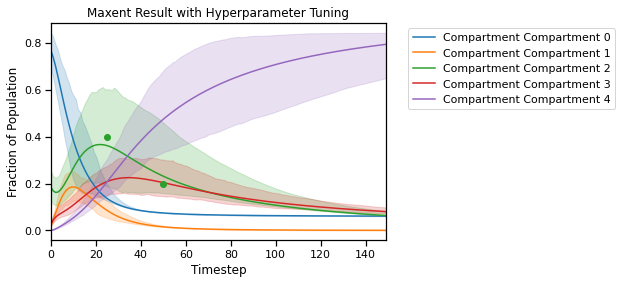

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

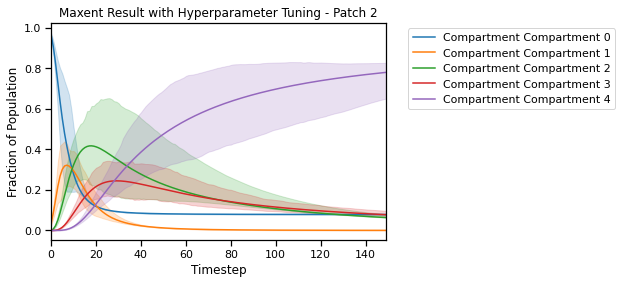

In [22]:
w = maxent_model.traj_weights
trajs = maxent_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Now compare with Directed regression

In [29]:
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
reg_model = maxentep.TrainableMetaModel(start, R, T, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [30]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 3s 34ms/step - loss: 0.1656 - output_2_loss: 0.1656


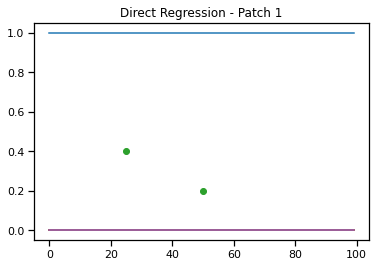

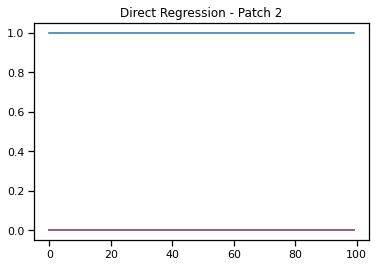

In [31]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()